In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Modèle 01

C'est le modèle le plus simple : une masse thermique ($m.C_p$) reliée à la température extérieure à travers une résistance thermique ($S.h$). Linéaire, 1er ordre, équivalent électrique RC.

Rq.: la température extérieure moyenne doit être égale à celle intérieure moyenne.

$$
m.C_p \, \frac{dT}{dt} = -S.h\,( T - T_{ext} )
$$

$m.Cp$ est la masse thermique, $S$ est la surface avec l'extérieure et $h$ le coefficient d'échange.

On pose:
$$
\beta = \frac{S.h}{m.C_p}
$$

et en pasant par la transformée de Fourier, on obtient: 
$$
\tilde T = \frac{\beta}{\beta + 2\pi\, i \, f } \tilde T_{ext}
$$

In [67]:
def model01_apply( beta,  T_ext, sample_freq=600 ):
    """ T_ext : np_array
        sample_freq : duré entre les points, en seconde
    """
    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    freq = np.fft.rfftfreq( T_ext.size, d=sample_freq)
    
    # modele
    TF_theo = beta/( beta + 2j*np.pi*freq )*TF_ext

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return T_theo

## Fit

In [150]:
from scipy.optimize import fmin

def errorfit( param, T_int, T_ext  ):
    T_theo = model01_apply( param, T_ext )
    return np.sum( (T_int - T_theo)**2 )
  

def model01_fit( T_int, T_ext ):
    
    betaZero = 3e-05

    res = fmin(errorfit, betaZero, disp=True, full_output = True, args=(T_int, T_ext))

    paramOpt, fopt = res[:2]
   
    return paramOpt[0]

In [151]:
errorfit( 2.655e-5, T_int, T_ext  )

8481.3143986147279

## Chargement des données depuis emonCMS

In [152]:
import emoncmsfeed as getfeeds

In [153]:
dataframefreq = '10min'
feeds =  { 'T_ext':2, 'T_int':3 }

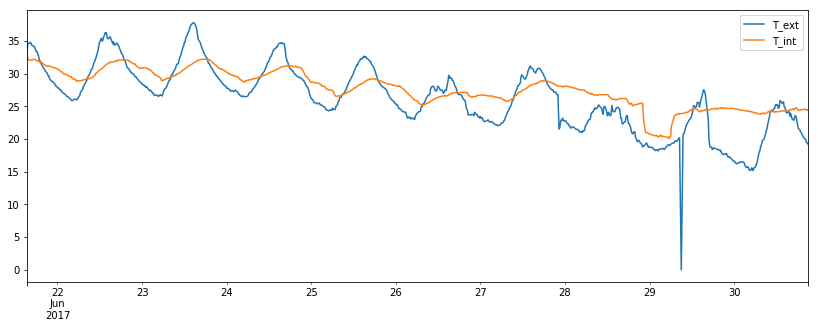

In [154]:
df = getfeeds.builddataframe( feeds, dataframefreq ) # startdate=pd.to_datetime('22/06/2017')
df.plot( figsize=(14, 5) );

In [155]:
df.mean()

T_ext    26.256399
T_int    27.687002
dtype: float64

In [156]:
# To array :
df = df.resample('10min').interpolate()
T_ext = df['T_ext'].as_matrix().flatten()
T_int = df['T_int'].as_matrix().flatten()

In [157]:
best_beta = model01_fit( T_int, T_ext )

print('---')
print('beta_opt: %e s-1'%best_beta)

print('1/beta : %.1f h'%(1/beta / 60/60))

Optimization terminated successfully.
         Current function value: 8184.929405
         Iterations: 11
         Function evaluations: 22
---
beta_opt: 3.842578e-05 s-1
1/beta : 7.2 h


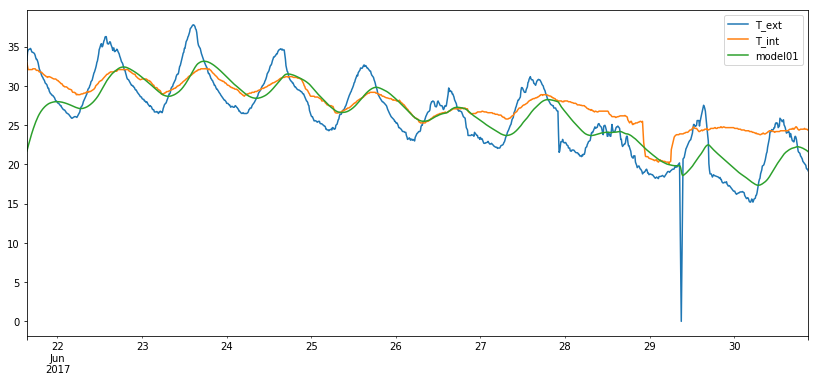

In [159]:
beta = best_beta  # 2.33e-05
T_theo = model01_apply( beta, T_ext )

df['model01'] = T_theo

df.plot( figsize=(14, 6)  )

## Résidus

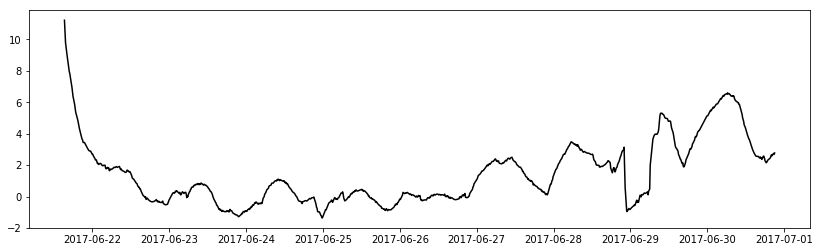

In [160]:
plt.figure( figsize=(14, 4) )
plt.plot_date( df.index,  T_int-T_theo, 'k')

# Avec les données météo ?

In [161]:
import weatherfeed as wf

In [193]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('20/06/2017'), pd.to_datetime('now')
#df.index[0], df.index[-1]

In [194]:
# download the data:
data = wf.buildmultidayDF(startday, lastday, coords_grenoble )

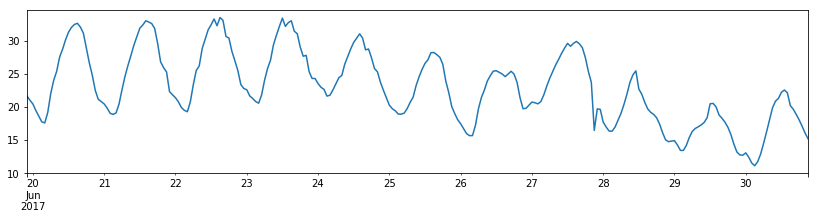

In [195]:
data['temperature'].plot( figsize=(14, 3) );

In [196]:
model_Tmeteo = pd.DataFrame()

In [197]:
Text_meteo = data['temperature'].resample('10min').interpolate()

In [198]:
# To array :
Tmeteo_array = Text_meteo.as_matrix().flatten()
#T_int = df['T_int'].as_matrix().flatten()

In [199]:
beta = best_beta
T_theo_array = model01_apply( beta, Tmeteo_array )

In [200]:
res_meteo = pd.DataFrame( {'T_theo':T_theo_array, 'T_ext':Tmeteo_array}, index= Text_meteo.index )

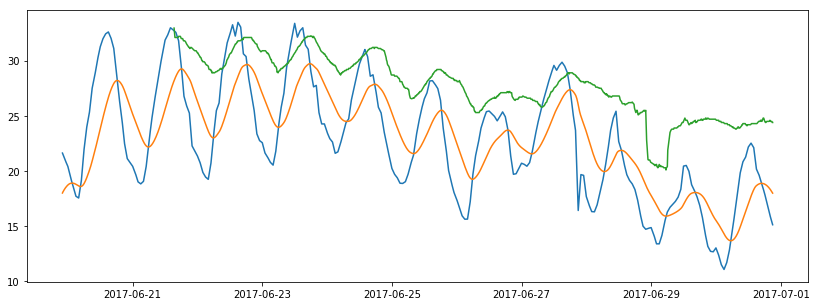

In [201]:
plt.figure( figsize=(14, 5) )
plt.plot( res_meteo )
plt.plot_date(df.index, df['T_int'], '-')

* il y a un offset: effet du soleil ? masse thermique longue ? 